In [1]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/../src/')
from stats_eda import replace_outliers_with_sd, replace_column_outliers
from stats_eda import run_ANOVA_plates, plot_by_plate, get_ttest_wells


In [2]:
file = '../BRI/PAM194_Keratino_CytoPanel_1/pam194ObjCell.pkl'
df = pd.read_pickle(file)
features = df.columns[6:]

### detect outliers by checking distributions performed between same experiments in different wells

In [16]:
from tqdm import tqdm

In [17]:
cdw = df.groupby(by=['Metadata_Metadata_Cytokine', 
                    'Metadata_Metadata_Dose',
                    'Metadata_Well']).mean().index

# n = 4
sds = [5,6]
idx_sd = {i:[] for i in sds}
idx_iqr = []
# running thru each pair of cytokine and dosage
for i in tqdm(cdw):
    c = i[0]
    d = i[1]
    w = i[2]
    # running thru every feature and find outliers
    for feature in features:
        # sub_df[feature] = replace_column_outliers(sub_df[feature]).values
        idx_sds = replace_outliers_with_sd(df, feature, c, d, w, sds)
        for k, v in zip(idx_sds.keys(), idx_sds.values()):
            idx_sd[k] += v
            # idx_sd[k] = list(set(idx_sd[k]))
        idx_iqr += replace_column_outliers(df, feature, c, d, w)
    

100%|██████████| 66/66 [07:44<00:00,  7.04s/it]


In [24]:
# count the appearance of one row in across all the variables

idx_iqr_cnt = Counter(idx_iqr)

In [1]:
# count the appearance of one row in across all the variables

idx_sds_cnt = {}
for k, v in zip(idx_sd.keys(), idx_sd.values()):
    idx_sds_cnt[k] = Counter(v)
idx_sds_cnt

In [26]:
# remove duplicate indexes

idx_iqr = list(set(idx_iqr))
for k, v in zip(idx_sds.keys(), idx_sds.values()):
    idx_sd[k] = list(set(idx_sd[k]))

### try removing points X sds away from the mean and see results from t-tests

In [28]:
print(len(idx_iqr))
for i in sds:
    print(len(idx_sd[i]))
print(df.shape)

64884
8882
5272
(94370, 104)


In [29]:
df_sd_removed = {i:df.drop(idx_sd[i], axis=0) for i in sds}
df_iqr = df.drop(idx_iqr, axis=0)
print(df_iqr.shape[0])
for i in sds:
    print(df_sd_removed[i].shape[0])

29486
85488
89098


In [30]:
# by plates
df_sd_removed_untr = {}
for k, v in zip(df_sd_removed.keys(), df_sd_removed.values()):
    tmp = pd.concat([v[v['Metadata_Metadata_Cytokine']=='untr'], v[v['Metadata_Metadata_Cytokine']=='untr-50']])
    df_sd_removed_untr[k] = tmp
# df_sd5_untr = pd.concat([df_sd5[df_sd5['Metadata_Metadata_Cytokine']=='untr'], df_sd5[df_sd5['Metadata_Metadata_Cytokine']=='untr-50']])
# df_sd6_untr = pd.concat([df_sd6[df_sd6['Metadata_Metadata_Cytokine']=='untr'], df_sd6[df_sd6['Metadata_Metadata_Cytokine']=='untr-50']])
df_iqr_untr = pd.concat([df_iqr[df_iqr['Metadata_Metadata_Cytokine']=='untr'], df_iqr[df_iqr['Metadata_Metadata_Cytokine']=='untr-50']])

print(df_iqr_untr.shape[0])
for i in sds:
    print(df_sd_removed_untr[i].shape[0])

2885
8196
8503


In [31]:
feature = 'Granularity_1_CorrActin'

In [46]:
print('IQR')
print(run_ANOVA_plates('untr', feature, df_iqr_untr))
print('5 sds')
print(run_ANOVA_plates('untr', feature, df_sd_removed_untr[5]))
print('6 sds')
print(run_ANOVA_plates('untr', feature, df_sd_removed_untr[6]))

IQR
(  Cytokine                  Feature      F-stat        P-value
0     untr  Granularity_1_CorrActin  257.900013  6.447053e-102, 1.0)
5 sds
(  Cytokine                  Feature      F-stat        P-value
0     untr  Granularity_1_CorrActin  443.984937  1.230771e-181, 1.0)
6 sds
(  Cytokine                  Feature      F-stat        P-value
0     untr  Granularity_1_CorrActin  444.957925  2.089994e-182, 1.0)


In [42]:
# cannot run ANOVA on untr-50 since there is only one plate
df_iqr_untr[df_iqr_untr['Metadata_Metadata_Cytokine']=='untr-50']['Metadata_Plate'].unique()

array(['Plate 3'], dtype=object)

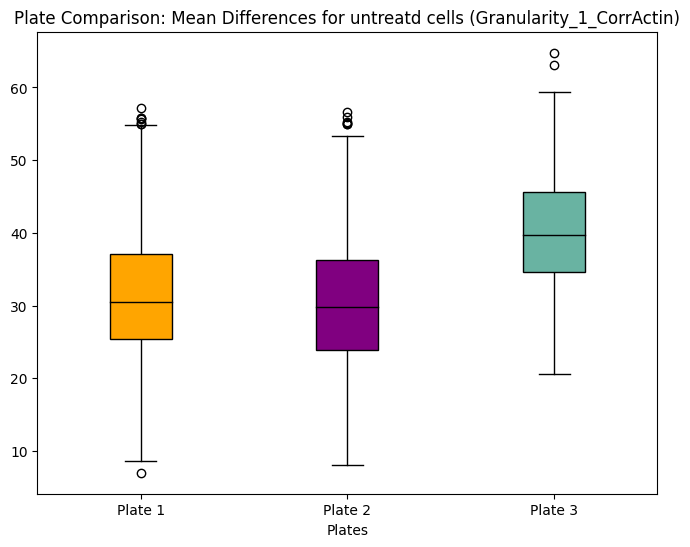

In [47]:
plot_by_plate('untr', feature, df_iqr_untr)

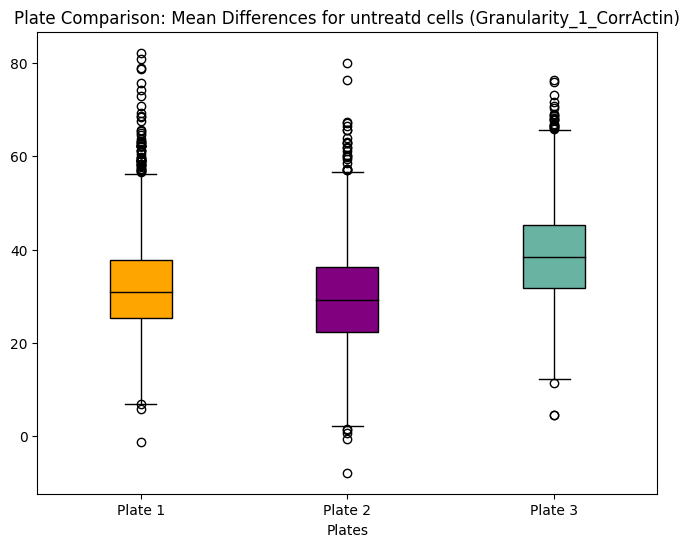

In [48]:
plot_by_plate('untr', feature, df_sd_removed_untr[5])

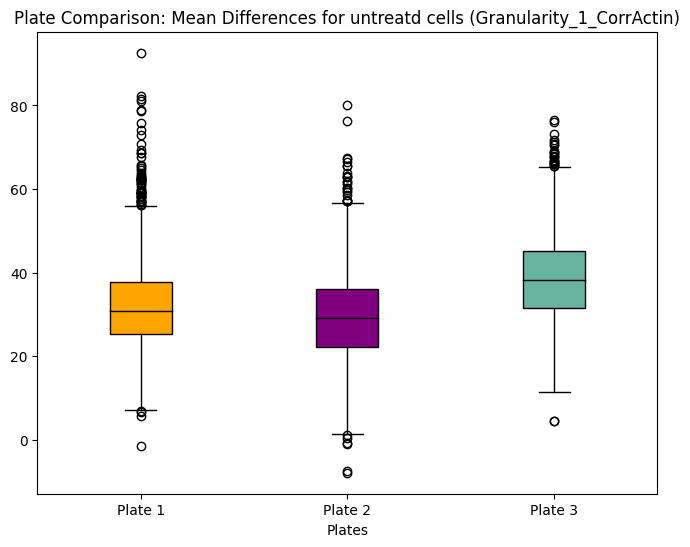

In [49]:
plot_by_plate('untr', feature, df_sd_removed_untr[6])

In [55]:
# made slight changes to Matthew's plate_Tukey_HSD here

from statsmodels.stats.multicomp import pairwise_tukeyhsd
def plate_Tukey_HSD(untr, feature, df):
    untr_plates = df[(df['Metadata_Metadata_Cytokine'] == untr)]
    untr_plates = untr_plates[['Metadata_Plate', feature]]
    
    res = pairwise_tukeyhsd(endog=untr_plates[feature],
                          groups=untr_plates['Metadata_Plate'],
                          alpha=0.05)
    
    return res

print('IQR')
print(plate_Tukey_HSD('untr', feature, df_iqr_untr))
print('5 sds')
print(plate_Tukey_HSD('untr', feature, df_sd_removed_untr[5]))
print('6 sds')
print(plate_Tukey_HSD('untr', feature, df_sd_removed_untr[6]))
print('original df')
print(plate_Tukey_HSD('untr', feature, df))
# eda.plate_Tukey_HSD('untr', feature, df_sd5_untr)

IQR
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Plate 1 Plate 2  -1.3453 0.0037 -2.3256  -0.365   True
Plate 1 Plate 3   8.4386    0.0  7.3656  9.5117   True
Plate 2 Plate 3    9.784    0.0  8.7166 10.8513   True
------------------------------------------------------
5 sds
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
Plate 1 Plate 2  -2.7005   0.0 -3.3921 -2.0088   True
Plate 1 Plate 3   6.8119   0.0  6.0281  7.5958   True
Plate 2 Plate 3   9.5124   0.0  8.7591 10.2657   True
-----------------------------------------------------
6 sds
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
Plate 1 Plate 2  -2.8281  -0.0 -3.5124 -2.1437   True
Plate

In [63]:
# by wells
for i in cdw:
    if i[0]=='untr' or i[0]=='untr-50':
        continue
    print(get_ttest_wells(i[0], feature, df_iqr))
# df_sd_removed_untr = {}
# for k, v in zip(df_sd_removed.keys(), df_sd_removed.values()):
#     tmp = pd.concat([v[v['Metadata_Metadata_Cytokine']=='untr'], v[v['Metadata_Metadata_Cytokine']=='untr-50']])
#     df_sd_removed_untr[k] = tmp
# df_iqr_untr = pd.concat([df_iqr[df_iqr['Metadata_Metadata_Cytokine']=='untr'], df_iqr[df_iqr['Metadata_Metadata_Cytokine']=='untr-50']])

# print(df_iqr_untr.shape[0])
# for i in sds:
#     print(df_sd_removed_untr[i].shape[0])

  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0      EGF  Granularity_1_CorrActin        F2 vs G2        1.749    0.081   

   Power  
0    1.0  
  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0      EGF  Granularity_1_CorrActin        F2 vs G2        1.749    0.081   

   Power  
0    1.0  
  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0      EGF  Granularity_1_CorrActin        F2 vs G2        1.749    0.081   

   Power  
0    1.0  
  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0      EGF  Granularity_1_CorrActin        F2 vs G2        1.749    0.081   

   Power  
0    1.0  
  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0      EGF  Granularity_1_CorrActin        F2 vs G2        1.749    0.081   

   Power  
0    1.0  
  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0      EGF  Granularity_1_CorrActin   

### add threshold to the last prompt by looking into out of all variables, in how many of those is a data point an outlier

### look at different groups of variables or different signals (DNA/WGA/Mito/Golgi)

In [ ]:
# features = df.columns[6:]
groups = ['Granularity', 'Intensity',
            'Texture_AngularSecondMoment', 
            'Texture_Contrast',
            'RadialDistribution_MeanFrac',
            'RadialDistribution_ZernikeMagnitude',
            'Area'
            ]
gran = df.filter(regex='Inten', axis=1).columns.tolist()